In [2]:
import numpy as np
import pandas as pd

from datetime import date

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Final Functions
parameters:
- sample size: N
- seed for randomization
- train-test split ratio

In [30]:
## Note: csv_file is not included in the repo

def get_sample(csv_file, N, seed):
    np.random.seed(seed)
    df = pd.read_csv(csv_file)
    
    #keep only ratings from the most recent 5 years： 2010-2015
    df['datetime'] = df['timestamp'].apply(lambda x: date.fromtimestamp(x))
    df['year'] = df['timestamp'].apply(lambda x: date.fromtimestamp(x).year)
    df = df[df['year']>=date.fromisoformat('2010-01-01').year]
    df.drop(['timestamp','year'],axis=1,inplace=True) #'timestamp' and 'year' no longer useful 
    
    #keep only movies with at least 20 ratings
    m_counts = df.groupby('movieId').size()
    m_index = m_counts[m_counts>=20].index
    df = df[df['movieId'].isin(m_index)]
    
    #keep only users who have rated at least 20 movies - consistent with original data
    u_counts = df.groupby('userId').size()
    u_index = u_counts[u_counts>=20].index
    df = df[df['userId'].isin(u_index)]
    
    #sample out N users
    users = np.unique(df['userId'])
    u_index_sample = np.random.choice(users, N)
    sample = df[df['userId'].isin(u_index_sample)]
    
#     #plot data
#     users_s, u_count_s = np.unique(sample['userId'], return_counts=True)
#     plt.plot(np.arange(1, len(users_s)+1), sorted(sample.groupby('userId').size(), reverse=True))
#     plt.xlabel('number of users')
#     plt.ylabel('number of rated movies')
#     plt.show()
    
    print('number of unique users:', len(np.unique(sample['userId'])))
    print('number of unique movies:', len(np.unique(sample['movieId'])))
    
    return sample


In [31]:
sample = get_sample('ratings.csv', 10000, 1)

number of unique users: 8450
number of unique movies: 9359


In [32]:
"""since original ratings.csv is too big (553.4M), saving the sample data for reference"""
#this entire cell could be commented out later
sample.to_csv('sample_data.csv')

In [34]:
def get_train_test(sample_data, split, seed):
    np.random.seed(seed)
    sample = pd.read_csv(sample_data)
#     sample = sample_data
    sample.drop(['Unnamed: 0'],axis=1,inplace=True) #original index no longer necessary
    
    train, test = train_test_split(sample, test_size=split)
    
    #check
    print('number of users in train:',len(np.unique(train['userId'])))
    print('number of movies in train:',len(np.unique(train['movieId'])))
    print('number of users in test:', len(np.unique(test['userId'])))
    print('number of movies in test:',len(np.unique(test['movieId'])))
    
    return train, test
    

In [35]:
train, test = get_train_test('sample_data.csv', 0.3, 1)

number of users in train: 8450
number of movies in train: 9350
number of users in test: 8449
number of movies in test: 9130


## Process

In [3]:
ratings = pd.read_csv('ratings.csv')
# ratings.drop(['timestamp'],axis=1,inplace=True)
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
ratings['year'] = ratings['timestamp'].apply(lambda x: date.fromtimestamp(x).year)
# ratings.sort_values('datetime', ascending=False, inplace=True)

In [6]:
ratings.head()

,userId,movieId,rating,timestamp,year
0,1,2,3.5,1112486027,2005
1,1,29,3.5,1112484676,2005
2,1,32,3.5,1112484819,2005
3,1,47,3.5,1112484727,2005
4,1,50,3.5,1112484580,2005


In [7]:
ratings.groupby('year').size()

year
1995          4
1996    1613004
1997     700639
1998     308018
1999    1198736
2000    1954193
2001    1186433
2002     869506
2003    1035777
2004    1170590
2005    1802450
2006    1171664
2007    1053496
2008    1159547
2009     929235
2010     903351
2011     766886
2012     731866
2013     598515
2014     562904
2015     283449
dtype: int64

In [9]:
ratings_1015 = ratings[ratings['year']>=date.fromisoformat('2010-01-01').year]
print(ratings_1015.shape)
print(ratings_1015.head())
ratings_1015.groupby('year').size()

(3846971, 5)
      userId  movieId  rating   timestamp  year
1175      11     4226     5.0  1294796159  2011
1231      11     5971     5.0  1294796201  2011
1239      11     6291     5.0  1294796113  2011
1267      11     7153     5.0  1294796132  2011
1315      11    30707     5.0  1294796176  2011


year
2010    903351
2011    766886
2012    731866
2013    598515
2014    562904
2015    283449
dtype: int64

In [11]:
ratings_1015.drop(['timestamp','year'],axis=1,inplace=True)
ratings_1015.head()

/Users/claire_y_feng/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,userId,movieId,rating
1175,11,4226,5.0
1231,11,5971,5.0
1239,11,6291,5.0
1267,11,7153,5.0
1315,11,30707,5.0


In [12]:
users, u_count = np.unique(ratings_1015['userId'], return_counts=True)
print(len(users))
movies, m_count = np.unique(ratings_1015['movieId'], return_counts=True)
print(len(movies))

30779
26302


In [13]:
#check for movie counts
counts = ratings_1015.groupby('movieId').size()
counts.describe()

count    26302.000000
mean       146.261539
std        592.770155
min          1.000000
25%          2.000000
50%          8.000000
75%         44.000000
max      14023.000000
dtype: float64

In [14]:
#remove movies with less than 20 ratings - too few ratings are meaningless
m_index = counts[counts>=20].index
ratings_1015 = ratings_1015[ratings_1015['movieId'].isin(m_index)]

In [15]:
#check for movie counts
counts = ratings_1015.groupby('movieId').size()
counts.describe()

count     9359.000000
mean       401.589807
std        941.435553
min         20.000000
25%         38.000000
50%         89.000000
75%        316.000000
max      14023.000000
dtype: float64

In [16]:
#check for user counts
ratings_1015.groupby('userId').size().describe()

count    30773.000000
mean       122.135606
std        182.982088
min          1.000000
25%         29.000000
50%         60.000000
75%        138.000000
max       3605.000000
dtype: float64

In [17]:
#mostly above 20 ratings
u_counts = ratings_1015.groupby('userId').size()
u_index = u_counts[u_counts>=20].index
u_index

Int64Index([    25,     31,     36,     42,     49,     59,     60,     62,
                65,     71,
            ...
            138460, 138465, 138468, 138471, 138472, 138473, 138476, 138479,
            138485, 138489],
           dtype='int64', name='userId', length=29080)

In [18]:
#down from 30773 to 29080 - still adequate
ratings_1015 = ratings_1015[ratings_1015['userId'].isin(u_index)]
print(ratings_1015.shape)
users = np.unique(ratings_1015['userId'])
print(len(users))
movies = np.unique(ratings_1015['movieId'])
print(len(movies))

(3744597, 3)
29080
9359


In [ ]:
# testing = ratings_1015.drop(['timestamp','datetime'],axis=1)
# testing.head()

In [19]:
np.random.seed(1)
u_index_sample = np.random.choice(users,10000)
print(len(u_index_sample))
sample = ratings_1015[ratings_1015['userId'].isin(u_index_sample)]

10000


In [20]:
len(np.unique(sample['userId']))

8450

In [21]:
sample.head()

,userId,movieId,rating
3534,31,1,3.0
3535,31,110,5.0
3536,31,260,5.0
3537,31,364,3.0
3538,31,527,0.5


In [22]:
users_sample, u_count_sample = np.unique(sample['userId'], return_counts=True)
print(len(users_sample))
movies_sample, m_count_sample = np.unique(sample['movieId'], return_counts=True)
print(len(movies_sample))

8450
9359


In [23]:
sample.groupby('userId').count().sort_values('movieId',ascending=False)

,movieId,rating
userId,,
15617,3605,3605
31122,3274,3274
105580,2955,2955
27053,2587,2587
62040,2173,2173
135090,2080,2080
98420,2050,2050
10514,1903,1903
99342,1823,1823


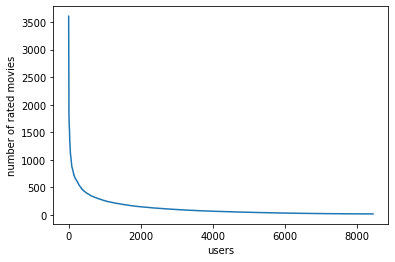

In [24]:
plt.plot(np.arange(1, len(users_sample)+1), sorted(sample.groupby('userId').size(), reverse=True))
plt.xlabel('users')
plt.ylabel('number of rated movies')
plt.show()

In [25]:
#train test split
# _50p = sample.groupby('userId').size().describe()[5]
# _50p
sample.groupby('userId').size().describe()

count    8450.000000
mean      127.479763
std       189.220184
min        20.000000
25%        32.000000
50%        64.000000
75%       143.000000
max      3605.000000
dtype: float64

In [ ]:
#no longer needed to set a minimum threshold
# print(len(users3),len(users3[u_count3<_50p]))
# user_train_ind = users3[u_count3<_50p]
# user_train_ind2 = users3[u_count3>=_50p]
# train1 = sample[sample['userId'].isin(user_train_ind)]

In [ ]:
# train1

In [26]:
# train, test = train_test_split(sample[sample['userId'].isin(user_train_ind2)], test_size = 0.3)
train, test = train_test_split(sample, test_size = 0.3)

In [ ]:
# train = train1.append(train2)

In [27]:
print(len(np.unique(sample['userId'])))
print(len(np.unique(sample['movieId'])))
sample.shape

8450
9359


(1077204, 3)

In [28]:
print(len(np.unique(train['userId'])))
print(len(np.unique(train['movieId'])))
train.shape

8450
9349


(754042, 3)

In [29]:
print(len(np.unique(test['userId'])))
print(len(np.unique(test['movieId'])))
test.shape

8448
9138


(323162, 3)